# House Prices Competition : Term Project 

#### Description:

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### Importing Libraries:

In [418]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [419]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [420]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [421]:
print ("Train data shape:", train.shape)

Train data shape: (1460, 81)


In [422]:
print ("Test data shape:", test.shape)

Test data shape: (1459, 80)


In [423]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Data preprocessing:

#### Skewness of the data :

Skewness is a measure of the degree of asymmetry of a distribution. If the left tail (tail at small end of the distribution) is more pronounced than the right tail (tail at the large end of the distribution), the function is said to have negative skewness. If the reverse is true, it has positive skewness. If the two are equal, it has zero skewness.
The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

Skew is: 1.88287575977


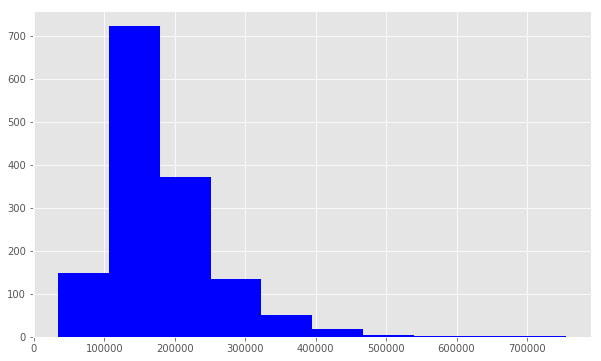

In [424]:
print ("Skew is:", train.SalePrice.skew())
plt.hist(train.SalePrice, color='blue')
plt.show()

We apply log function to have zero skew 

Skew is: 0.121335062205


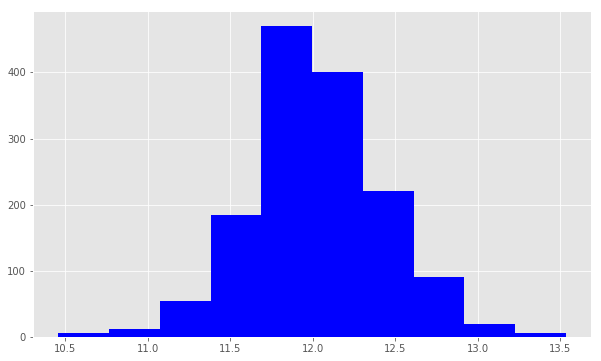

In [425]:
target = np.log(train.SalePrice)
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

### Dealing with outliers:

#### Ground Living Area feature :

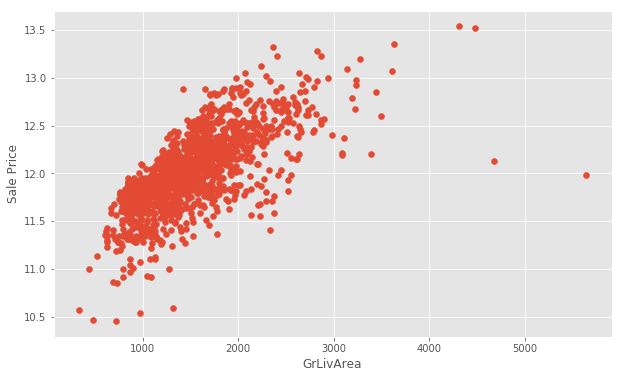

In [426]:
plt.scatter(x=train['GrLivArea'], y=np.log(train.SalePrice))
plt.ylabel('Sale Price')
plt.xlabel('GrLivArea')
plt.show()

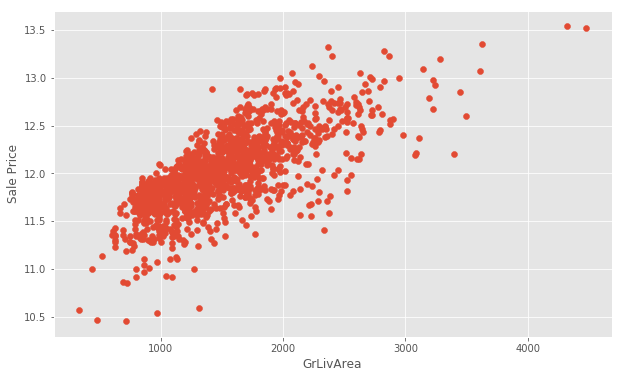

In [427]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

plt.scatter(x=train['GrLivArea'], y=np.log(train.SalePrice))
plt.ylabel('Sale Price')
plt.xlabel('GrLivArea')
plt.show()

In [428]:
train.shape

(1458, 81)

#### GarageArea feature:

GarageArea: Size of garage in square feet


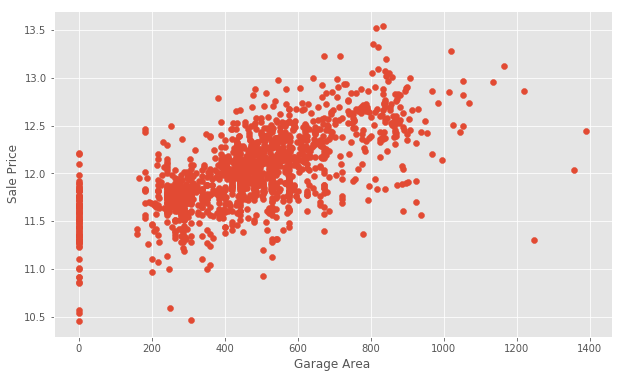

In [429]:
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice))
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

In [430]:
train = train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<120000)].index)
#test = test[test['GarageArea'] < 1200]

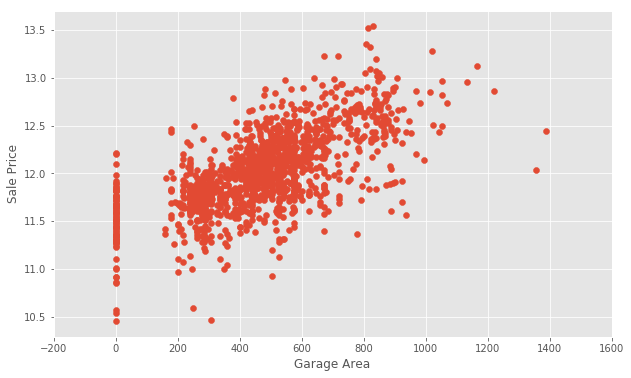

In [431]:
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice))
plt.xlim(-200,1600) # This forces the same scale as before
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

In [432]:
train.shape

(1457, 81)

### feature engineering :

### Handling non-numerical features :

First we will deal with features with null values that could be significant, for example :
- PoolQC: null value means the house doesn't have a pool
- MiscFeature
- Alley
- Fence
- FireplaceQu  
- MSSubClass


In [433]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu','MSSubClass','MasVnrArea'):
    train[col] = train[col].fillna('None')

In [434]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu','MSSubClass','MasVnrArea'):
    test[col] = test[col].fillna('None')

For other features like Basement type, having nul value means there is no basement, this is why we should fill it with zeros

In [435]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)

In [436]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    test[col] = test[col].fillna(0)

In [437]:
test.shape

(1459, 80)

let's discover the _utilities_ feature

In [438]:
train['Utilities'].unique()

array(['AllPub', 'NoSeWa'], dtype=object)

In [439]:
train['Utilities'].value_counts()

AllPub    1456
NoSeWa       1
Name: Utilities, dtype: int64

We see that mostly all our data sample have AllPub value, this is why this feature is not very usefull for our model, se we drop it

In [440]:
train = train.drop(['Utilities'], axis=1)

In [441]:
test = test.drop(['Utilities'], axis=1)

for Functional feature, data description says null value means typical

In [442]:
train["Functional"] = train["Functional"].fillna("Typ")

In [443]:
test["Functional"] = test["Functional"].fillna("Typ")

In [444]:
test.shape

(1459, 79)

#### Handling ordinal features:
Some features are represented in ordered wayn such as Garage Quality, so we will try to lebel them according to this order.

In [445]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].values)) 
    train[c] = lbl.transform(list(train[c].values))

# shape        
print('Shape all_data: {}'.format(train.shape))

Shape all_data: (1457, 80)


In [446]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(test[c].values)) 
    test[c] = lbl.transform(list(test[c].values))

# shape        
print('Shape all_data: {}'.format(test.shape))

Shape all_data: (1459, 79)


In [447]:
train[['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']].head(5)

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,...,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
0,3,2,3,4,4,2,4,0,3,2,...,0,3,2,1,1,1,5,4,2,1
1,5,2,3,4,4,3,4,0,3,3,...,0,3,2,1,1,1,0,7,1,4
2,5,2,3,4,4,2,4,0,3,2,...,0,0,2,1,1,1,5,4,2,8
3,2,3,1,4,4,3,4,2,3,2,...,0,0,2,1,1,1,6,4,0,1
4,5,2,3,4,4,2,4,0,3,2,...,0,0,2,1,1,1,5,4,2,11


In [448]:
test[['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']].head(5)

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,...,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
0,3,3,3,3,4,3,4,4,2,3,...,0,3,2,1,1,1,0,5,4,5
1,3,3,3,3,4,3,4,4,2,2,...,0,0,2,1,1,1,0,5,4,5
2,5,2,3,3,4,3,4,2,2,3,...,0,0,2,1,1,1,5,4,4,2
3,2,3,3,3,4,3,4,0,2,2,...,0,0,2,1,1,1,5,5,4,5
4,3,2,3,3,4,2,4,0,2,2,...,0,0,2,1,1,1,11,4,4,0


In [449]:
# we can add a feature of the total area of the house 
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

In [450]:
# we can add a feature of the total area of the house 
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

### Handling numerical features

We noticed from the data that there are some categorical features represented as numerical features (integers), for example GarageCars and MSSubClass

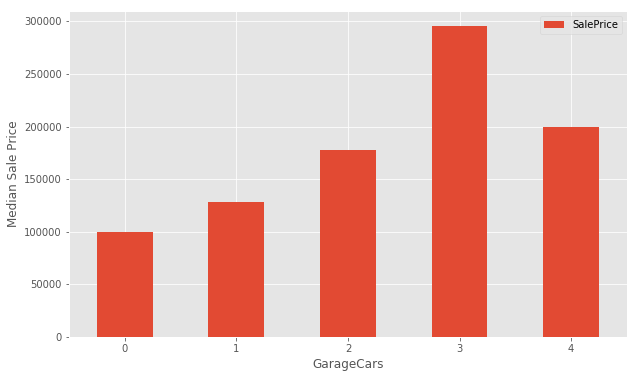

In [451]:
garage_pivot = train.pivot_table(index='GarageCars',
                                    values='SalePrice', aggfunc=np.median)
garage_pivot.plot(kind='bar')
plt.xlabel('GarageCars')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

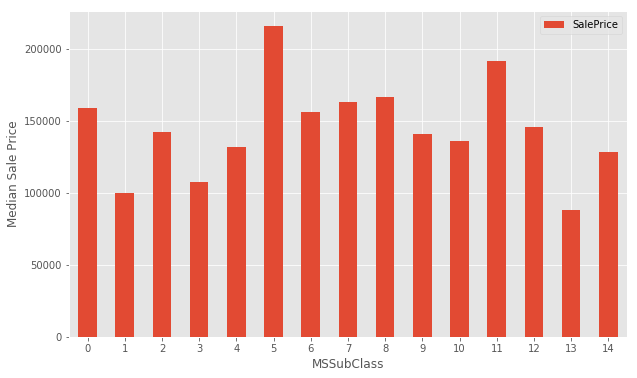

In [452]:
mssubclass_pivot = train.pivot_table(index='MSSubClass',
                                    values='SalePrice', aggfunc=np.median)
mssubclass_pivot.plot(kind='bar')
plt.xlabel('MSSubClass')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [453]:
#MSSubClass=The building class
train['MSSubClass'] = train['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
train['OverallCond'] = train['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

In [454]:
#MSSubClass=The building class
test['MSSubClass'] = test['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
test['OverallCond'] = test['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
test['YrSold'] = test['YrSold'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)

In [455]:
test.shape

(1459, 80)

### Methods to handle Null values :

In [456]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
LotFrontage,259
GarageType,81
MasVnrType,8
Electrical,1
TotalSF,0
Foundation,0
Exterior1st,0
Exterior2nd,0
MasVnrArea,0


We still have some null value, we will try to read the data description adn understand better what they mean.

LotFrontage: Linear feet of street connected to property, which means we can replace it with zeros

In [457]:
train["LotFrontage"] = train["LotFrontage"].fillna(0)
test["LotFrontage"] = test["LotFrontage"].fillna(0)

Null values in the garage type feature means there is no garage, se we can fill it with zero too :

In [458]:
train["MasVnrType"] = train["MasVnrType"].fillna(0)
test["MasVnrType"] = test["MasVnrType"].fillna(0)

In [459]:
train["GarageType"] = train["GarageType"].fillna(0)
test["GarageType"] = test["GarageType"].fillna(0)

In [460]:
train["Electrical"] = train["Electrical"].fillna(0)
test["Electrical"] = test["Electrical"].fillna(0)

In [461]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
TotalSF,0
HeatingQC,0
RoofMatl,0
Exterior1st,0
Exterior2nd,0
MasVnrType,0
MasVnrArea,0
ExterQual,0
ExterCond,0


## Building the model:

In [462]:
train_set = train.select_dtypes(include=[np.number])
test_set = test.select_dtypes(include=[np.number])
train_set.head(5)

,Id,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,YearBuilt,YearRemodAdd,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,SalePrice,TotalSF
0,1,65.0,8450,1,1,3,0,7,2003,2003,...,61,0,0,0,0,3,4,0,208500,2566
1,2,80.0,9600,1,1,3,0,6,1976,1976,...,0,0,0,0,0,3,4,0,181500,2524
2,3,68.0,11250,1,1,0,0,7,2001,2002,...,42,0,0,0,0,3,4,0,223500,2706
3,4,60.0,9550,1,1,0,0,7,1915,1970,...,35,272,0,0,0,3,4,0,140000,2473
4,5,84.0,14260,1,1,0,0,8,2000,2000,...,84,0,0,0,0,3,4,0,250000,3343


In [463]:
test_set.head(5)

,Id,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,YearBuilt,YearRemodAdd,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,TotalSF
0,1461,80.0,11622,1,1,3,0,5,1961,1961,...,140,0,0,0,120,0,2,2,0,1778.0
1,1462,81.0,14267,1,1,0,0,6,1958,1958,...,393,36,0,0,0,0,2,4,12500,2658.0
2,1463,74.0,13830,1,1,0,0,5,1997,1998,...,212,34,0,0,0,0,2,2,0,2557.0
3,1464,78.0,9978,1,1,0,0,6,1998,1998,...,360,36,0,0,0,0,2,4,0,2530.0
4,1465,43.0,5005,1,1,0,0,8,1992,1992,...,0,82,0,0,144,0,2,4,0,2560.0


In [464]:
# apply log again (because we used skew before)
y = np.log(train.SalePrice)
X = train_set.drop(['Id'], axis=1)

train_test_split() returns four objects:

* X_train is the subset of our features used for training.
* X_test is the subset which will be our 'hold-out' set - what we'll use to test the model.
* y_train is the target variable SalePrice which corresponds to X_train.
* y_test is the target variable SalePrice which corresponds to X_test. 

random_state=42 allow reproducible results.

In [465]:
from sklearn.model_selection import train_test_split
#first option
X_train, X_test, y_train, y_test = train_test_split(
                                   X, y, random_state=42, test_size=.33)

In [466]:
learning_rates = np.arange(0.0, 0.09, 0.0015)
learning_rates
best_learning_rates = [0.0885, 0.0735, 0.0705, 0.0615, 0.06, 0.0585, 0.057, 0.0555]

In [467]:
# XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

Xtrain = X_train.as_matrix()
Xtest = X_test.as_matrix()
XGBoost = XGBRegressor(n_estimators = 1000,learning_rate=0.0585)


XGBoost.fit(X_train, y_train)
prediction = XGBoost.predict(X_test)
#print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

print ("R^2 is: \n", XGBoost.score(X_test, y_test))



R^2 is: 
 0.994773004493


### More algorithms:

In [468]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import lightgbm as lgb


In [469]:
# Lasso regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso.fit(X_train, y_train)
print ("R^2 is: \n", lasso.score(X_test, y_test))

R^2 is: 
 0.936909227337


In [470]:
# Elastic Net regression
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet.fit(X_train, y_train)
print ("R^2 is: \n", ENet.score(X_test, y_test))

R^2 is: 
 0.936951365272


In [471]:
# Gradient boosting regression
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

GBoost.fit(X_train, y_train)
print ("R^2 is: \n", GBoost.score(X_test, y_test))


R^2 is: 
 0.966889062252


In [472]:
# LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [473]:
model_lgb.fit(X_train, y_train)
print ("R^2 is: \n", model_lgb.score(X_test, y_test))

R^2 is: 
 0.967702918554


In [474]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [475]:
averaged_models = AveragingModels(models = (ENet, GBoost, model_lgb, lasso))

averaged_models.fit(Xtrain, y_train)
print ("R^2 is: \n", averaged_models.score(Xtest, y_test))


R^2 is: 
 0.961785398956


### Making a submission

In [476]:
submission = pd.DataFrame()
submission['Id'] = test.Id

In [477]:
feats = test_set.as_matrix()#.drop(['Id'], axis=1)
feats.shape

(1459, 55)

In [478]:
predictions = averaged_models.predict(feats)
final_predictions = predictions


In [479]:
submission['SalePrice'] = final_predictions
submission.head()
#submission.shape


,Id,SalePrice
0,1461,1.003340e+15
1,1462,4.434173e+15
2,1463,3.713736e+17
3,1464,2.726405e+17
4,1465,6.083572e+15


In [480]:
submission.to_csv('submission_feature_engineering.csv', index=False)